# LSTM Architecture 

In order to effectively use an LSTM, we need to figure out the optimal architecture of the nueral network. We need to hyperparameterize the optimization.

In the following cells we will preprocess the data to best fit all of our models

In [51]:
# Import Necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.metrics import mean_squared_error
from math import sqrt
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the complete raw data set that was provided 
data_path  = "../data/ucsbdata.csv"
raw_data = pd.read_csv(data_path)

In [3]:
# Selected only data after the market crash 
initial_start = '2008-08-30'
data = raw_data.loc[raw_data.Index > initial_start]

In [4]:
# Convert Int Values to float
non_floats = ['URR', 'FOMC', 'PPIR', 'SIM', 'HULBERTSENTIMENT', 'TOM']
for i in non_floats:
    data[i] = data[i].astype(float)

In [5]:
# Convert string to datatype to a dataframe
index_datatime = pd.to_datetime(data['Index']).values
data['Index'] = index_datatime
# Replace current index with data index 
data.set_index('Index', inplace = True)
data.head(5)

,R,US10YR,EPS,PER,OPEN,HIGH,LOW,CLOSE,BDIY,VIX,...,MYSTERYVAR3,TOM,HULBERTSENTIMENT,BUBBLE,CASH,DEBT,DIVIDEND,RETURN,STOCKS,WAR
Index,,,,,,,,,,,,,,,,,,,,,
2008-09-02,-0.000925,3.7326,49.78,25.664524,1287.83,1303.04,1272.20,1277.58,6466.0,21.99,...,12.805545,1.0,11.7,102.145351,80.224149,52.613405,42.572673,20.866767,32.085132,43.392387
2008-09-03,-0.021012,3.6990,49.78,25.612294,1276.61,1280.60,1265.59,1274.98,6146.0,21.43,...,12.747167,0.0,-2.1,87.724831,76.736143,59.870426,37.019715,22.681269,35.522825,40.981699
2008-09-04,0.003075,3.6227,49.76,24.855908,1271.80,1271.80,1232.83,1236.83,5874.0,24.03,...,12.790740,0.0,-2.1,96.136801,81.386818,62.591809,45.040654,21.169184,36.668722,43.995059
2008-09-05,0.020380,3.6986,49.76,24.966037,1233.21,1244.94,1217.23,1242.31,5663.0,23.06,...,12.944056,0.0,-2.1,99.741931,81.386818,61.684682,42.572673,20.866767,38.960517,44.597731
2008-09-08,-0.021026,3.6743,49.75,25.483216,1249.50,1274.42,1247.12,1267.79,5492.0,22.64,...,12.891218,0.0,-9.0,98.540221,80.224149,54.427660,45.040654,20.564351,38.960517,47.611092


In [6]:
# Predict for the latest complete year of 2018
test_year = '2018'
# test data frame for 2018
test_df = data.loc[test_year]
test_df

,R,US10YR,EPS,PER,OPEN,HIGH,LOW,CLOSE,BDIY,VIX,...,MYSTERYVAR3,TOM,HULBERTSENTIMENT,BUBBLE,CASH,DEBT,DIVIDEND,RETURN,STOCKS,WAR
Index,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.006251,2.4633,108.43,24.861813,2683.73,2695.89,2682.36,2695.81,1230.0,9.77,...,10.955137,1.0,57.69,62.306837,137.061468,37.641296,70.374485,37.584248,60.597745,33.839705
2018-01-03,0.004152,2.4471,108.48,25.021376,2697.85,2714.37,2697.77,2713.06,1262.0,9.15,...,10.969012,0.0,57.57,59.442155,134.475403,43.616105,81.593606,41.139515,64.637595,34.591698
2018-01-04,0.006588,2.4525,108.48,25.109653,2719.31,2729.29,2719.07,2723.99,1341.0,9.22,...,10.948341,0.0,57.57,60.874496,134.475403,48.395952,89.752967,42.663200,77.767106,34.591698
2018-01-05,0.001773,2.4763,108.49,25.283674,2731.33,2743.45,2727.92,2743.15,1371.0,9.22,...,10.955443,0.0,57.57,60.158325,129.303272,48.395952,87.713126,40.631619,81.806956,33.087711
2018-01-08,0.002205,2.4800,108.49,25.324593,2742.67,2748.51,2737.60,2747.71,1385.0,9.52,...,10.936525,0.0,62.33,61.590666,129.303272,47.798471,83.633446,39.107934,72.717294,33.087711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,0.022629,2.7383,132.51,17.696918,2400.56,2410.34,2351.10,2351.10,1271.0,36.07,...,12.133489,0.0,-11.74,61.833407,145.063192,41.207903,76.017489,32.030824,51.823052,31.871601
2018-12-26,0.007556,2.8079,132.50,18.622795,2363.12,2467.76,2346.58,2467.70,1271.0,30.41,...,12.338862,1.0,-14.94,55.718015,120.402449,29.434217,55.868275,28.959375,44.785354,32.472952
2018-12-27,-0.001382,2.7666,132.51,18.778925,2442.50,2489.10,2397.94,2488.83,1271.0,29.96,...,12.115016,1.0,-15.59,67.948799,121.853081,36.498429,57.700022,39.051278,47.344517,37.283760


In [7]:
# Training data frame from 2008 - 2017
train_df = data.loc[:'2017']
train_df

,R,US10YR,EPS,PER,OPEN,HIGH,LOW,CLOSE,BDIY,VIX,...,MYSTERYVAR3,TOM,HULBERTSENTIMENT,BUBBLE,CASH,DEBT,DIVIDEND,RETURN,STOCKS,WAR
Index,,,,,,,,,,,,,,,,,,,,,
2008-09-02,-0.000925,3.7326,49.78,25.664524,1287.83,1303.04,1272.20,1277.58,6466.0,21.99,...,12.805545,1.0,11.70,102.145351,80.224149,52.613405,42.572673,20.866767,32.085132,43.392387
2008-09-03,-0.021012,3.6990,49.78,25.612294,1276.61,1280.60,1265.59,1274.98,6146.0,21.43,...,12.747167,0.0,-2.10,87.724831,76.736143,59.870426,37.019715,22.681269,35.522825,40.981699
2008-09-04,0.003075,3.6227,49.76,24.855908,1271.80,1271.80,1232.83,1236.83,5874.0,24.03,...,12.790740,0.0,-2.10,96.136801,81.386818,62.591809,45.040654,21.169184,36.668722,43.995059
2008-09-05,0.020380,3.6986,49.76,24.966037,1233.21,1244.94,1217.23,1242.31,5663.0,23.06,...,12.944056,0.0,-2.10,99.741931,81.386818,61.684682,42.572673,20.866767,38.960517,44.597731
2008-09-08,-0.021026,3.6743,49.75,25.483216,1249.50,1274.42,1247.12,1267.79,5492.0,22.64,...,12.891218,0.0,-9.00,98.540221,80.224149,54.427660,45.040654,20.564351,38.960517,47.611092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,-0.001248,2.4810,108.43,24.747972,2684.22,2685.35,2678.13,2683.34,1366.0,9.90,...,10.979090,0.0,61.07,63.739178,162.922123,46.603509,76.494006,37.076353,54.537971,33.839705
2017-12-26,0.000431,2.4756,108.43,24.719929,2679.09,2682.74,2677.96,2680.50,1366.0,10.25,...,10.972110,1.0,56.31,63.739178,160.336057,37.043815,71.394405,34.028981,54.537971,32.335718
2017-12-27,0.002001,2.4107,108.43,24.739268,2682.10,2685.64,2678.91,2682.62,1366.0,10.47,...,10.966183,1.0,55.24,71.617054,131.889338,31.069006,55.075684,42.155305,47.468234,35.343692


In [8]:
# Create test dataset and test labels
test_labels = test_df['R'].values
print("Length of test labels: ",len(test_labels))
test_data = test_df.iloc[:, 1:].values
print("Length of test data: ", len(test_data))
print("The shape of test data: ", test_data.shape)
print("The shape of test labels", test_labels.shape)
# Store index for test data
test_index = test_df.index.values
print("The length of test index: ", len(test_index))

Length of test labels:  251
Length of test data:  251
The shape of test data:  (251, 66)
The shape of test labels (251,)
The length of test index:  251


In [14]:
# Create Training and validation set: Split data with 80% train and 20 % val
train_sp_returns = train_df['R'].values
train_features = train_df.iloc[:, 1:].values

val_perc = 0.2
train_data, val_data, train_labels, val_labels = train_test_split(train_features,
                                                                    train_sp_returns,
                                                                    test_size = val_perc, 
                                                                    random_state = 0,
                                                                   shuffle = False)

# Split training index
train_index = test_df.index[:1880].values
val_index = test_index[1881:]

print("Lenth of train data: ", len(train_data))
print("Length of train labels: ", len(train_labels))
print("Length of validation data:", len(val_data))
print("Length of validation labels", len(val_labels))
print("Shape of train data: ", train_data.shape)
print("Shape of validation data: ", val_data.shape)

Lenth of train data:  1880
Length of train labels:  1880
Length of validation data: 470
Length of validation labels 470
Shape of train data:  (1880, 66)
Shape of validation data:  (470, 66)


In [15]:
# Normalize the data from training data 
sc = StandardScaler()

train_data = sc.fit_transform(train_data)
val_data = sc.transform(val_data)
test_data = sc.transform(test_data)

# Values should be close to 0
print(np.mean(train_data))
print(np.mean(val_data))
print(np.mean(test_data))

# Values should be close to 1
print(np.std(train_data))
print(np.std(val_data))
print(np.std(test_data))

1.372524846123314e-15
0.2979949687651302
0.7261257494184662
1.0
1.363435333868144
2.290018933621589


In [93]:
# Generate data to best fit LSTM
sampling_rate = 1 # The period at which sample data i.e  1 Day, we dont skip data points
lookback = 5 # how many timesteps back to look
train_batch_size = 20 # How many mini-batches to train
val_batch_size = 1 # should update daily
test_batch_size = 1 # Should update daily

train_generator = TimeseriesGenerator(train_data, train_labels,
                                     length = lookback,
                                     batch_size = train_batch_size, sampling_rate = sampling_rate,
                                     shuffle = False)
validation_generator = TimeseriesGenerator(val_data, val_labels, 
                                          length = lookback, 
                                          batch_size = val_batch_size, sampling_rate = sampling_rate,
                                          shuffle = False)

test_generator  = TimeseriesGenerator(test_data, test_labels, 
                                     length = lookback, batch_size = test_batch_size,
                                     sampling_rate = sampling_rate, shuffle = False)

# Base model with no optimization

In [110]:
# Base model with 2 hidden layers
def build_base_model():
    base_model = Sequential()
    base_model.add(LSTM(128,
                  activation = 'relu',
                  input_shape = (lookback, train_data.shape[1]), return_sequences = True))
    base_model.add(Dropout(0.25))
    base_model.add(LSTM(64,
                       activation = 'relu',
                       input_shape = (lookback, train_data.shape[1])))
    base_model.add(Dense(1))
    base_model.compile(optimizer = 'ADAM', loss = 'mse', metrics = [mean_squared_error])
    return base_model

In [111]:
base_model = build_base_model()
history = base_model.fit(train_generator, validation_data = validation_generator, epochs = 40)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1875 steps, validate for 465 steps
Epoch 1/40
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/40
1875/1875 [==============================] - 21s 11ms/step - loss: 1.5643e-04 - mean_squared_error: 1.5643e-04 - val_loss: 3.2752e-05 - val_mean_squared_error: 3.2752e-05
Epoch 3/40
1875/1875 [==============================] - 21s 11ms/step - loss: 1.3709e-04 - mean_squared_error: 1.3709e-04 - val_loss: 3.3316e-05 - val_mean_squared_error: 3.3316e-05
Epoch 4/40
1875/1875 [==============================] - 22s 12ms/step - loss: 1.1217e-04 - mean_squared_error: 1.1217e-04 - val_loss: 3.5651e-05 - val_mean_squared_error: 3.5651e-05
Epoch 5/40
1875/1875 [==============================] - 22s 12ms/step - loss: 1.2156e-04 - mean_squared_error: 1.2156e-04 - val_loss: 6.0272e-05 - val_mean_squared_error: 6.0272e-05
Epoch 6/40


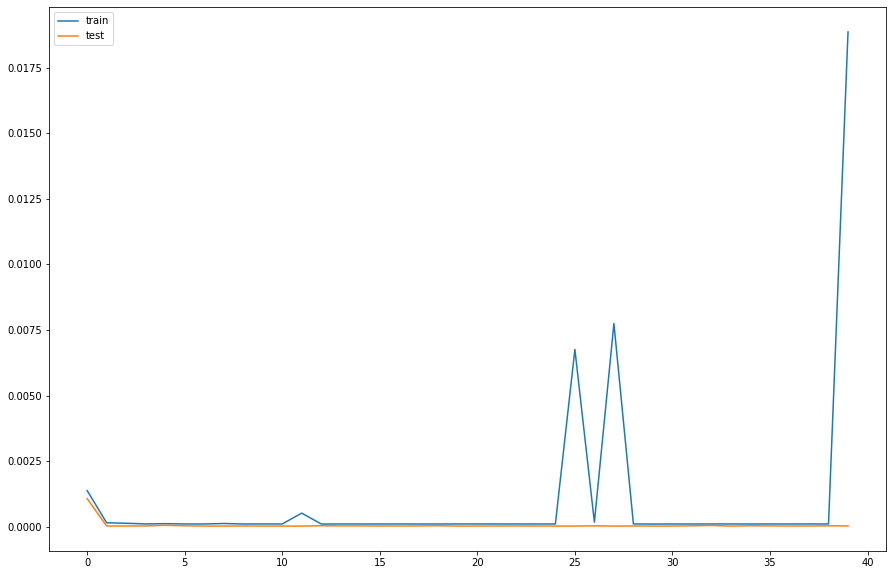

In [112]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [113]:
# Prediction on test set
base_predictions = base_model.predict(test_generator)

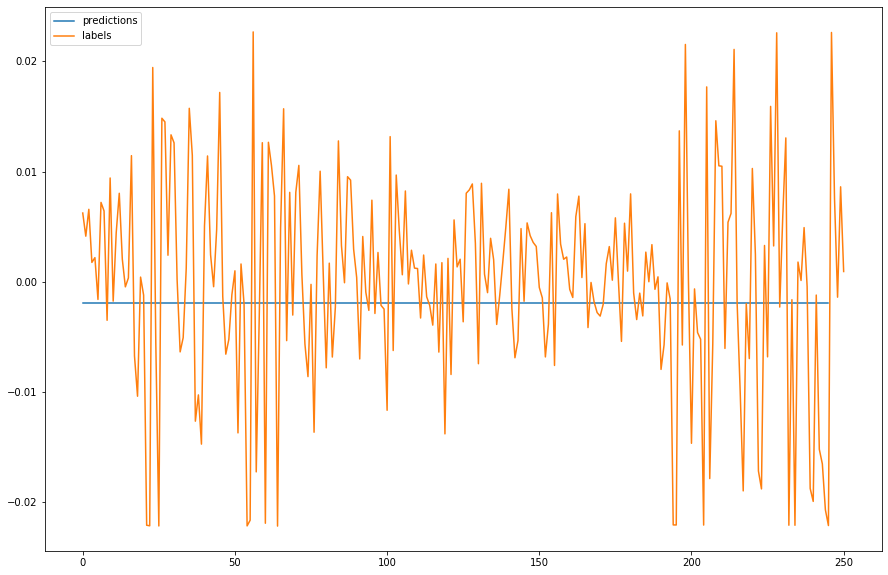

In [114]:
# Plot predictions against actual labels
plt.figure(figsize=(15,10))
plt.plot(base_predictions, label='predictions')
plt.plot(test_labels, label='labels')
plt.legend()

In [115]:
# Calculate RMSE
